# MOT Test Data Generation

This notebook generates synthetic MOT test data for analysis. The assignment requires:
  - Tabular data with at least 500 rows
  - Non-tabular data generated with AI
  - Explanation of generation and field distributions

**Author:** Gabriel Guimaraes

**Date:** 6.11.25

**Module:** Practical Data Analytics Level 5

## 1. Import required libraries

We'll use:
  - **pandas**: Data manipulation and `DataFrames`
  - **numpy**: Numerical operations and random number generation
  - **faker**: Generate realistic fake data (names, addresses, dates, etc.)
  - **sqlite3/sqlalchemy**: Database creation and management
  - **datetime**: Date handeling

In [118]:
import pandas as pd
import numpy as np
from faker import Faker
from datetime import datetime, timedelta
import random
from sqlalchemy import create_engine
from pathlib import Path
import os

fake = Faker('en_GB')
np.random.seed(16)  # For reproducibility

print("Libraries imported successfully!")

Libraries imported successfully!


## 2. Define Data Generation Parameters

Setting up the scale of our synthetic dataset:
  - **500 vehicles** (minimum requirement)
  - **1000 MOT tests** (vehicles can have multiple tests)
  - **20 test centres** across UK regions
  - **50 examiners** conducting tests

We also define realistic distributions for vehicle makes, fuel types, and regions based on UK MOT statistics.

In [119]:
# Define Data Generation Parameters
NUM_VEHICLES = 500
NUM_TESTS = 1000
NUM_TEST_CENTRES = 20
NUM_EXAMINERS = 50

# Vehicle makes and models 
VEHICLE_MAKES = ['Ford', 'Vauxhall', 'Volkswagen', 'BMW', 'Mercedes', 'Audi', 'Toyota', 'Nissan']
VEHICLE_MODELS = {
  'Ford': ['Fiesta', 'Focus', 'Mondeo', 'Kuga', 'Transit'],
  'Vauxhall': ['Corsa', 'Astra', 'Insignia', 'Mokka'],
  'Volkswagen': ['Golf', 'Polo', 'Passat', 'Tiguan'],
  'BMW': ['3 Series', '5 Series', 'X3', '1 Series'],
  'Mercedes': ['C-Class', 'E-Class', 'A-Class', 'GLC'],
  'Audi': ['A3', 'A4', 'Q3', 'Q5'],
  'Toyota': ['Yaris', 'Corolla', 'RAV4', 'Aygo'],
  'Nissan': ['Qashqai', 'Juke', 'Micra', 'Leaf']
}

FUEL_TYPES = ['Petrol', 'Diesel', 'Electric', 'Hybrid']
UK_REGIONS = ['London', 'South East', 'North West', 'Midlands', 'Scotland', 'Wales', 'South West', 'North East', 'Yorkshire']
DEFECT_CATEGORIES = ['Brakes', 'Tyres', 'Lights', 'Suspension', 'Steering', 'Exhaust', 'Body', 'Registration Plates', 'Seatbelts']
DEFECT_SEVERITIES = ['DANGEROUS', 'MAJOR', 'MINOR', 'ADVISORY']

print("Data generation parameters defined.")


Data generation parameters defined.


## 3. Generate Vehicle Data 

Creating the **vehicles** table with 500 records. Each vehicle has:
  - Unique vehicle_id and registration plate
  - Make and model from realistic UK distributions
  - Fuel type 
  - Registration date between 2010-2023
  - Vehicle class (most are class 4 - standard cars. subtypes: A-J)

This represents the foundational data for our MOT analysis.

In [120]:
def generate_vehicles(num_vehicles) -> pd.DataFrame:
    """Generate synthetic vehicle data."""
    vehicles = []

    for i in range(num_vehicles):
        make = random.choice(VEHICLE_MAKES)
        model = random.choice(VEHICLE_MODELS[make])

        registration_date = fake.date_between(start_date='-15y', end_date='-2y')
        registration = fake.license_plate()

        # Data: https://assets.publishing.service.gov.uk/media/66bdf9923cc0741b923146e1/ntsq09029.ods
        fuel_type = np.random.choice(FUEL_TYPES, p=[0.61, 0.31, 0.02, 0.06])  # Weighted probabilities base on 2023 data
        vehicle_class = '4'  # Most vehicles are class 4 (standard cars)

        vehicle = {
            'vehicle_id': i + 1,
            'registration': registration,
            'make': make,
            'model': model,
            'fuel_type': fuel_type,
            'registration_date': registration_date,
            'vehicle_class': vehicle_class 
        }

        vehicles.append(vehicle)


    return pd.DataFrame(vehicles)

vehicles_df = generate_vehicles(NUM_VEHICLES)
print(f"Generated {len(vehicles_df)} vehicles.")
print(f"\nVehicle Make Distribution:")
print(vehicles_df['make'].value_counts())
vehicles_df.head()
        

Generated 500 vehicles.

Vehicle Make Distribution:
make
Mercedes      79
BMW           68
Nissan        67
Audi          67
Vauxhall      66
Toyota        53
Ford          50
Volkswagen    50
Name: count, dtype: int64


,vehicle_id,registration,make,model,fuel_type,registration_date,vehicle_class
0,1,IQ26GEX,Mercedes,GLC,Petrol,2014-04-26,4
1,2,TD24 NWD,Toyota,RAV4,Petrol,2018-03-07,4
2,3,PJ74OPL,Toyota,Corolla,Petrol,2015-03-15,4
3,4,IE70 ZBP,BMW,X3,Petrol,2011-10-25,4
4,5,KK83ZFL,Vauxhall,Corsa,Petrol,2023-11-16,4


## 4. Generate Test Centre Data

Creating 20 MOT test centres distributed across UK regions. Each centre has:
  - Unique centre_id
  - Realistic company name
  - Location (city)
  - Region for geographic analysis
  - UK postcode

This allows us to analyse regional variations in MOT outcomes.

In [121]:
def generate_test_centres(num_centres) -> pd.DataFrame:
    """Generate synthetic test centre data."""
    centres = []

    for i in range(num_centres):
        name = f"{fake.city()} Test Centre"
        # Remove postcode from location to avoid redundancy
        location = fake.address().rsplit(' ', 2)[0].replace('\n', ', ')
        region = random.choice(UK_REGIONS)
        postcode = fake.postcode()
        centre = {
            'centre_id': i + 1,
            'name': name,
            'location': location,
            'region': region,
            'postcode': postcode
        }
        centres.append(centre)

    return pd.DataFrame(centres)

test_centres_df = generate_test_centres(NUM_TEST_CENTRES)
print(f"Generated {len(test_centres_df)} test centres.")
print(f"\nTest Centre Region Distribution:")
print(test_centres_df['region'].value_counts())
test_centres_df.head()


Generated 20 test centres.

Test Centre Region Distribution:
region
South East    5
North East    4
Wales         3
North West    2
London        2
South West    2
Scotland      1
Yorkshire     1
Name: count, dtype: int64


,centre_id,name,location,region,postcode
0,1,Julieton Test Centre,"Studio 69, Clark",North West,BN1B 7QP
1,2,Shawhaven Test Centre,"6 Lees canyon, South",North East,E40 9EH
2,3,West Andrea Test Centre,"Flat 40, Martin",North East,SG1A 1FW
3,4,East Kevin Test Centre,578 Clarke,Wales,SE0N 3HE
4,5,Forsterfort Test Centre,"Flat 8, Waters",South East,BA7Y 4FH


## 5. Generate Examiner Data

Creating 50 MOT examiners who conduct the tests. Each examiner has:
- Unique examiner_id
- Realistic name
- Years of experience (2-25 years)
- Assigned to a specific test centre

This data could be used for analysing examiner consistency and experience effects on test outcomes.

In [122]:
def generate_examiners(num_examiners, test_centres_df) -> pd.DataFrame:
    """Generate synthetic examiner data."""
    examiners = []

    for i in range(num_examiners):
        name = fake.name()
        years_experience = random.randint(2, 25)
        centre_id = random.choice(test_centres_df['centre_id'].tolist())

        examiner = {
            'examiner_id': i + 1,
            'name': name,
            'years_experience': years_experience,
            'centre_id': centre_id
        }
        examiners.append(examiner)

    return pd.DataFrame(examiners)

examiners_df = generate_examiners(NUM_EXAMINERS, test_centres_df)
print(f"Generated {len(examiners_df)} examiners.")
print(f"\nExaminer Experience Distribution:")
print(examiners_df['years_experience'].describe())
examiners_df.head()

Generated 50 examiners.

Examiner Experience Distribution:
count    50.000000
mean     13.440000
std       6.725401
min       2.000000
25%       8.000000
50%      14.000000
75%      18.750000
max      25.000000
Name: years_experience, dtype: float64


,examiner_id,name,years_experience,centre_id
0,1,Norman Smith-Pearce,4,12
1,2,Ms Shirley Foster,12,5
2,3,Ms Kathleen Cooper,7,10
3,4,Nicole Powell,11,11
4,5,Lisa Dodd,6,19


## 6. Generate MOT Test Data (Main Table)

This is the **core fact table** with 1000 MOT test records. The generation includes **realistic business logic**:

**Age-based failure probability:**
- Under 3 years: 95% pass rate (new vehicles)
- 4-6 years: 85% pass rate
- 7-10 years: 70% pass rate
- Over 10 years: 60% pass rate

**Make-based reliability:**
- Toyota/Honda: +10% pass rate (known reliability)
- Land Rover/Fiat: -10% pass rate (known issues)

**Realistic mileage:** Average 7,000-15,000 miles per year with variation

This creates patterns suitable for hypothesis testing.

In [123]:
def generate_mot_tests(num_tests, vehicles_df, test_centres_df, examiners_df) -> pd.DataFrame:
    """
    Generate synthetic MOT test data with realistic failure patterns.
    """

    tests = []

    for i in range(num_tests):
        # Pick a random vehicle
        vehicle = vehicles_df.sample(1).iloc[0]
        # Generate test date (last 3 years)
        test_date = fake.date_between(start_date='-3y', end_date='today')
        # Calculate vehicle age at test date
        reg_date = pd.to_datetime(vehicle['registration_date'])
        test_date_dt = pd.to_datetime(test_date)
        vehicle_age_years = (test_date_dt - reg_date).days / 365.25
        if vehicle_age_years < 0:
            vehicle_age_years = 3.0 # Assume minimum age of 3 years if negative
        # Realistic mileage based on age (average 10,000 mile/year with variation)
        avg_annual_mileage = random.randint(7000, 15000)
        mileage = int(vehicle_age_years * avg_annual_mileage * np.random.uniform(0.8, 1.2))
        mileage = max(0, mileage)  # Ensure non-negative mileage

        # Pass/Fail logic based on vehicle age and realistic probabilities
        # Older vehicles more likely to fail
        if vehicle_age_years < 3:
            pass_probability = 0.95
        elif vehicle_age_years < 6:
            pass_probability = 0.85
        elif vehicle_age_years < 10:
            pass_probability = 0.70
        else:
            pass_probability = 0.50


        # Some makes are more reliable
        reliable_makes = ['Toyota', 'Honda']
        if vehicle['make'] in reliable_makes:
            pass_probability += 0.05

        test_result = np.random.choice(['PASS', 'FAIL'], p=[pass_probability, 1 - pass_probability])

        test = {
            'test_id': i + 1,
            'vehicle_id': vehicle['vehicle_id'],
            'centre_id': random.choice(test_centres_df['centre_id'].tolist()),
            'test_date': test_date,
            'test_result': test_result,
            'mileage': mileage,
            'vehicle_age_at_test': round(vehicle_age_years, 1),
            'examiner_id': random.choice(examiners_df['examiner_id'].tolist())
        }
        tests.append(test)

    return pd.DataFrame(tests)

mot_tests_df = generate_mot_tests(NUM_TESTS, vehicles_df, test_centres_df, examiners_df)
print(f"Generated {len(mot_tests_df)} MOT tests.")
print(f"\nMOT Test Result Distribution:")
print(mot_tests_df['test_result'].value_counts(normalize=True))
print(f"\nFauilure Rate: {mot_tests_df['test_result'].value_counts(normalize=True).get('FAIL', 0):.2%}")
mot_tests_df.head()
          

Generated 1000 MOT tests.

MOT Test Result Distribution:
test_result
PASS    0.715
FAIL    0.285
Name: proportion, dtype: float64

Fauilure Rate: 28.50%


,test_id,vehicle_id,centre_id,test_date,test_result,mileage,vehicle_age_at_test,examiner_id
0,1,499,10,2023-09-19,FAIL,82374,8.1,29
1,2,353,18,2023-02-13,FAIL,143053,12.1,8
2,3,97,7,2023-10-21,PASS,67879,7.8,26
3,4,355,5,2024-01-15,PASS,110049,10.6,15
4,5,468,11,2025-02-16,PASS,72997,9.2,31


## 7. Generate Test Defects

For each **failed** MOT test, we generate 1-4 defects explaining why it failed. Each defect includes:
- Defect category (Brakes, Tyres, Lights, etc.)
- Severity level (Dangerous, Major, Minor, Advisory)
- Realistic description

**Severity distribution:**
- Dangerous: 10% (immediate safety risk)
- Major: 35% (fails MOT)
- Minor: 35% (fails MOT)
- Advisory: 20% (doesn't fail, but noted)

This creates rich data for analysing common failure patterns.

In [124]:
def generate_test_defects(mot_test_df) -> pd.DataFrame:
    """Generate synthetic defect data for failed MOT tests."""
    defects = []
    failed_tests = mot_test_df[mot_test_df['test_result'] == 'FAIL']

    defect_id = 1
    for _, test in failed_tests.iterrows():
        # Each failed test has 1-4 defects
        num_defects = random.randint(1, 4)

        for _ in range(num_defects):
            category = random.choice(DEFECT_CATEGORIES)

            # Severity distribution (more minors than majors/dangerous)
            severity = np.random.choice(
                DEFECT_SEVERITIES,
                p=[0.1, 0.3, 0.5, 0.1]  # DANGEROUS, MAJOR, MINOR, ADVISORY
            )

            # Generate realistic defect description
            # DISCLAIMER: These are AI generated descriptions for realism
            defect_description = {
                'Brakes': f"Brake pad thickness below minimum on {random.choice(['front', 'rear'])} {random.choice(['left', 'right'])}.",
                'Tyres': f"Tyre tread depth below minimum on {random.choice(['front', 'rear'])} {random.choice(['left', 'right'])}.",
                'Lights': f"{random.choice(['Headlight', 'Indicator', 'Brake light'])} not working on {random.choice(['left', 'right'])} side.",
                'Suspension': f"Suspension component {random.choice(['worn', 'damaged', 'corroded'])}",
                'Steering': "Excessive play in steering mechanism",
                'Exhaust': f"Exhaust emission levels exceed maximum permitted for {random.choice(['diesel', 'petrol'])} vehicles",
                'Body': "Sharp edge on bodywork that could cause injury",
                'Registration Plates': "Registration plate insecure",
                'Seatbelts': f"{random.choice(['Driver', 'Passenger'])} seatbelt buckle not working correctly"
            }

            defect = {
                'defect_id': defect_id,
                'test_id': test['test_id'],
                'defect_category': category,
                'defect_severity': severity,
                'defect_description': defect_description[category]
            }
            defects.append(defect)
            defect_id += 1

    return pd.DataFrame(defects)

defects_df = generate_test_defects(mot_tests_df)
print(f"Generated {len(defects_df)} defects for failed MOT tests.")
print(f"\nDefect Severity Distribution:")
print(defects_df['defect_severity'].value_counts(normalize=True))
print(f"\nDefect Category Distribution:")
print(defects_df['defect_category'].value_counts(normalize=True))
defects_df.head()


Generated 722 defects for failed MOT tests.

Defect Severity Distribution:
defect_severity
MINOR        0.479224
MAJOR        0.326870
ADVISORY     0.101108
DANGEROUS    0.092798
Name: proportion, dtype: float64

Defect Category Distribution:
defect_category
Lights                 0.131579
Registration Plates    0.127424
Tyres                  0.121884
Brakes                 0.119114
Seatbelts              0.109418
Suspension             0.106648
Steering               0.102493
Body                   0.094183
Exhaust                0.087258
Name: proportion, dtype: float64


,defect_id,test_id,defect_category,defect_severity,defect_description
0,1,1,Brakes,MAJOR,Brake pad thickness below minimum on front right.
1,2,1,Body,MAJOR,Sharp edge on bodywork that could cause injury
2,3,2,Exhaust,MAJOR,Exhaust emission levels exceed maximum permitt...
3,4,2,Tyres,MINOR,Tyre tread depth below minimum on front left.
4,5,2,Registration Plates,MAJOR,Registration plate insecure


## 8. Visualise Data Distributions

**ASSIGNMENT REQUIREMENT:** Show the distribution of values in the fields and explain rationale.

Creating visualisations to show:
1. **Vehicle age distribution** - Shows our age range is realistic (3-13 years)
2. **Test results** - Shows pass/fail ratio
3. **Defect severity** - Shows most defects are Major/Minor (realistic)
4. **Vehicle makes** - Shows our make distribution
5. **Mileage distribution** - Shows realistic mileage patterns
6. **Defect categories** - Shows which defects are most common

These distributions will be included in the report to demonstrate data quality.

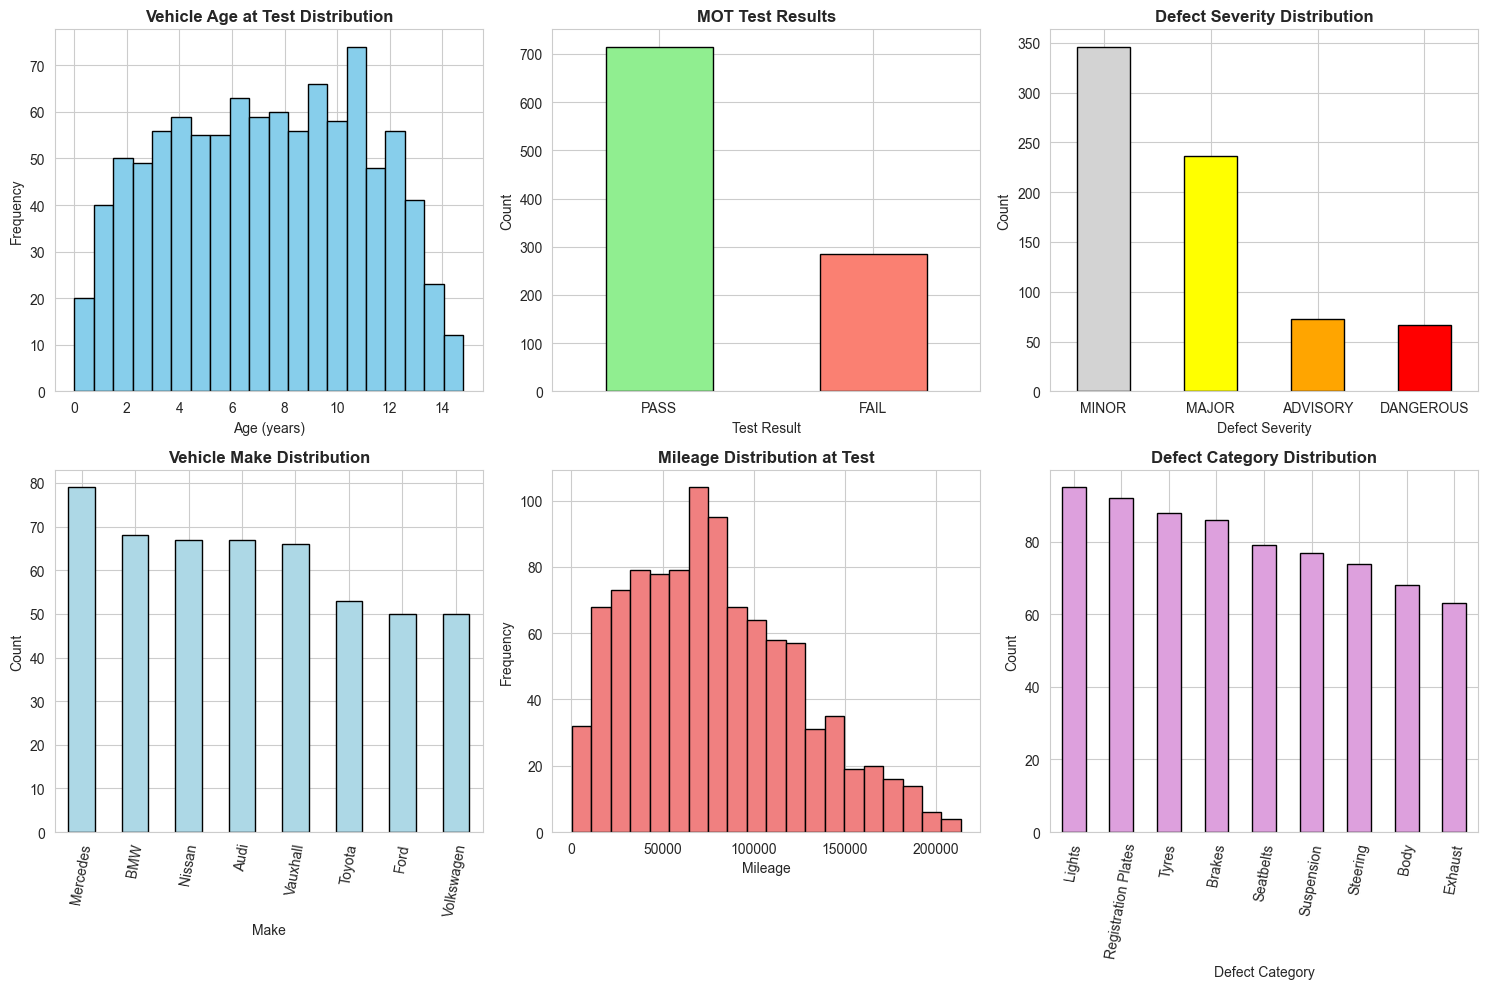

Visualisations created and saved.


In [125]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_style(style="whitegrid")
plt.rcParams['figure.facecolor'] = 'white'

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# 1. Vehicle Age Distribution
axes[0, 0].hist(mot_tests_df['vehicle_age_at_test'], bins=20, edgecolor='black', color='skyblue')
axes[0, 0].set_title('Vehicle Age at Test Distribution', fontweight='bold')
axes[0, 0].set_xlabel('Age (years)')
axes[0, 0].set_ylabel('Frequency')

# 2. Test Results
mot_tests_df['test_result'].value_counts().plot(kind='bar', ax=axes[0, 1], color=['lightgreen', 'salmon'], edgecolor='black')
axes[0, 1].set_title('MOT Test Results', fontweight='bold')
axes[0, 1].set_xlabel('Test Result')
axes[0, 1].set_ylabel('Count')
axes[0, 1].set_xticklabels(axes[0, 1].get_xticklabels(), rotation=0)

# 3. Defect Severity
defects_df['defect_severity'].value_counts().plot(kind='bar', ax=axes[0, 2], color=['lightgrey', 'yellow', 'orange', 'red'], edgecolor='black')
axes[0, 2].set_title('Defect Severity Distribution', fontweight='bold')
axes[0, 2].set_xlabel('Defect Severity')
axes[0, 2].set_ylabel('Count')
axes[0, 2].set_xticklabels(axes[0, 2].get_xticklabels(), rotation=0)

# 4. Vehicle Make Distribution
vehicles_df['make'].value_counts().plot(kind='bar', ax=axes[1,0], color='lightblue', edgecolor='black')
axes[1, 0].set_title('Vehicle Make Distribution', fontweight='bold')
axes[1, 0].set_xlabel('Make')
axes[1, 0].set_ylabel('Count')
axes[1, 0].set_xticklabels(axes[1, 0].get_xticklabels(), rotation=80)

# 5. Mileage Distribution
axes[1, 1].hist(mot_tests_df['mileage'], bins=20, edgecolor='black', color='lightcoral')
axes[1, 1].set_title('Mileage Distribution at Test', fontweight='bold')
axes[1, 1].set_xlabel('Mileage')
axes[1, 1].set_ylabel('Frequency')

# 6. Defect Category Distribution
defects_df['defect_category'].value_counts().plot(kind='bar', ax=axes[1, 2], color='plum', edgecolor='black')
axes[1, 2].set_title('Defect Category Distribution', fontweight='bold')
axes[1, 2].set_xlabel('Defect Category')
axes[1, 2].set_ylabel('Count')
axes[1, 2].set_xticklabels(axes[1, 2].get_xticklabels(), rotation=80)


plt.tight_layout()
plt.savefig('../data/visualisations/vehicle_age_distribution_vehicle.png')
plt.show()

print("Visualisations created and saved.")

## 9. Insert into SQL Database

Now we load all our generated data into a **SQLite database**. This demonstrates:
- Structured data storage
- Relational database design
- Data architecture implementation

In [126]:
# Create database file if it doesn't exist
db_path = Path(os.getcwd()) / '../data/database.sqlite3'
db_path.parent.mkdir(parents=True, exist_ok=True)
db_path.touch(exist_ok=True)

# Create database engine
engine = create_engine(f'sqlite:///{db_path}', echo=False)

# Load data into SQL database
vehicles_df.to_sql('vehicles', engine, if_exists='replace', index=False)
test_centres_df.to_sql('test_centres', engine, if_exists='replace', index=False)
examiners_df.to_sql('examiners', engine, if_exists='replace', index=False)
mot_tests_df.to_sql('mot_tests', engine, if_exists='replace', index=False)
defects_df.to_sql('test_defects', engine, if_exists='replace', index=False)

print("Data loaded into SQLite database successfully!")
print("\nTables created:")
print(f"  • vehicles:      {len(vehicles_df):,} records")
print(f"  • test_centres:  {len(test_centres_df):,} records")
print(f"  • examiners:     {len(examiners_df):,} records")
print(f"  • mot_tests:     {len(mot_tests_df):,} records")
print(f"  • test_defects:  {len(defects_df):,} records")

Data loaded into SQLite database successfully!

Tables created:
  • vehicles:      500 records
  • test_centres:  20 records
  • examiners:     50 records
  • mot_tests:     1,000 records
  • test_defects:  722 records
